**Chapter 4 – Training Models**

_This notebook contains all the sample code and solutions to the exercises in chapter 4._

This project requires Python 3.7 or above:

In [2]:
import sys
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from packaging import version
from math import ceil
from copy import deepcopy
from pathlib import Path
from sklearn.datasets import load_iris
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert sys.version_info >= (3, 7)

In [4]:
IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Exercise solutions

## 1. to 11.

1. If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation or the SVD approach because the computational complexity grows quickly (more than quadratically) with the number of features.
2. If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values.
3. Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model because the cost function is convex. _Convex_ means that if you draw a straight line between any two points on the curve, the line never crosses the curve.
4. If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.
5. If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.
6. Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.
7. Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.
8. If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an ℓ₂ penalty (Ridge) or an ℓ₁ penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.
9. If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter _α_.
10. Let's see:
  * A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
  * Lasso Regression uses an ℓ₁ penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
  * Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to 1.
11. If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
Exercise: _Implement Batch Gradient Descent with early stopping for Softmax Regression without using Scikit-Learn, only NumPy. Use it on a classification task such as the iris dataset._

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [ ]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

: 

We need to add the bias term for every instance ($x_0 = 1$). The easiest option to do this would be to use Scikit-Learn's `add_dummy_feature()` function, but the point of this exercise is to get a better understanding of the algorithms by implementing them manually. So here is one possible implementation:

In [ ]:
X_with_bias = np.c_[np.ones(len(X)), X]

: 

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but again, we want to do it manually:

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

: 

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for any given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance. To understand this code, you need to know that `np.diag(np.ones(n))` creates an n×n matrix full of 0s except for 1s on the main diagonal. Moreover, if `a` is a NumPy array, then `a[[1, 3, 2]]` returns an array with 3 rows equal to `a[1]`, `a[3]` and `a[2]` (this is [advanced NumPy indexing](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing)).

In [ ]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

: 

Let's test this function on the first 10 instances:

In [ ]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

: 

In [ ]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

: 

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

: 

Now let's scale the inputs. We compute the mean and standard deviation of each feature on the training set (except for the bias feature), then we center and scale each feature in the training set, the validation set, and the test set:

In [ ]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

: 

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

: 

We are almost ready to start training. Let's define the number of inputs and outputs:

In [ ]:
n_inputs = X_train.shape[1]  # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (there are 3 iris classes)

: 

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [ ]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.14519367480830644
2000 0.1301309575504088
3000 0.12009639326384539
4000 0.11372961364786884
5000 0.11002459532472425


: 

And that's it! The Softmax model is trained. Let's look at the model parameters:

In [ ]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

: 

Let's make predictions for the validation set and check the accuracy score:

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

: 

Well, this model looks pretty ok. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [ ]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


: 

Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

: 

In this case, the $\ell_2$ penalty did not change the test accuracy. Perhaps try fine-tuning `alpha`?

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [ ]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


: 

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

: 

Oh well, still no change in validation accuracy, but at least early stopping shortened training a bit.

Now let's plot the model's predictions on the whole dataset (remember to scale all features fed to the model):

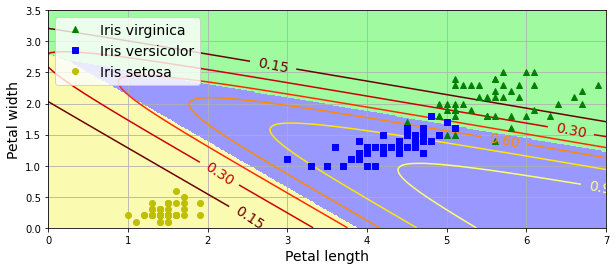

: 

In [ ]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

And now let's measure the final model's accuracy on the test set:

In [ ]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667

: 

Well we get even better performance on the test set. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.

: 